In [2]:
import tarfile
import pandas as pd
import numpy as np
from zipfile import ZipFile
from typing import List

# modeling
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras

# data visualization
import matplotlib.pyplot as plt

2025-02-09 23:02:41.881467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def extract_csv_files(archive_path: str, headers: List[str]) -> pd.DataFrame:
    if archive_path.endswith(".tar.gz"):
        with tarfile.open(archive_path, "r:gz") as tar:
            output = pd.concat([pd.read_csv(tar.extractfile(file), encoding="latin-1")
                               for file in tar.getnames()])

    if archive_path.endswith(".zip"):
        zip_file = ZipFile(archive_path)

        output = pd.concat([pd.read_csv(zip_file.open(csv_file), header=None)
                            for csv_file in zip_file.namelist()])

    if headers:
        output.columns = headers

    return output

### Traffic Preprocessing

In [4]:
traffic_file_archives = ["../data/citypulse_traffic_raw_data_aarhus_aug_sep_2014.tar.gz",
                         "../data/citypulse_traffic_raw_data_aarhus_oct_nov_2014.zip",
                         ]

headers = ["status", "avg_measured_time", "avg_speed",	"ext_id",
           "median_measured_time", "timestamp", "vehicle_count", "_id", "report_id"]

traffic_data = pd.concat([extract_csv_files(archive, headers)
                          for archive in traffic_file_archives])

traffic_meta_data = pd.read_csv("../data/trafficMetaData.csv")

traffic_data = traffic_data.merge(traffic_meta_data,
                                  how="left",
                                  left_on="report_id",
                                  right_on="REPORT_ID")

traffic_data["timestamp"] = pd.to_datetime(traffic_data["timestamp"])

### Reshape data for LSTM input

In [5]:
timestamp_index = pd.DataFrame({"timestamp": pd.date_range(pd.to_datetime(
    traffic_data["timestamp"].min()), pd.to_datetime(traffic_data["timestamp"].max()), freq="5min").to_list()})

ext_ids = np.sort(traffic_data["ext_id"].unique())

ts_df = pd.pivot_table(traffic_data[["timestamp", "ext_id", "avg_speed"]],
                       columns="ext_id",
                       index="timestamp",
                       values="avg_speed",
                       dropna=False)

ts_df = timestamp_index.merge(ts_df, how="left", left_on="timestamp",
                              right_index=True).set_index("timestamp", drop=True)

ts_df.interpolate(inplace=True)
ts_df = ts_df.dropna()

ts_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [6]:
ts_df.shape

(29984, 449)

In [7]:
training_sample = ts_df[100:20000]
validation_sample = ts_df[20001:]

In [8]:
# generate sequences of training data

# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 
features = 449 

sensor = pd.Series(training_sample.columns).sample(
    features, replace=False).sort_values().to_list()

print(sensor)

seq_arrays = []
seq_labs = []

training_features = training_sample[sensor]

for i in range(training_features.shape[0]-seq_length-ph):
    seq_arrays.append(training_features.iloc[i:seq_length+i].to_numpy())
    seq_labs.append(training_features.iloc[seq_length+ph+i])

seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

[610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809,

In [9]:
# create validation dataset
val_arrays = []
val_labs = []

validation_features = validation_sample[sensor]

for i in range(validation_features.shape[0]-seq_length-ph):
    if i < 12:
        val_arrays.append(validation_features.iloc[:(i+1)].to_numpy())
        val_labs.append(validation_features.iloc[:(i+ph+1)].to_numpy()[-1])
    else:
        val_arrays.append(validation_features.iloc[i:seq_length+i].to_numpy())
        val_labs.append(validation_features.iloc[seq_length+i+ph])

val_arrays = pad_sequences(val_arrays, padding='pre',
                           dtype=object).astype(np.float32)

val_labs = np.array(val_labs, dtype=object).astype(np.float32)

In [10]:
# define path to save model
model_path = 'lstm_traffic_only_1.keras'

# build the network
features = len(sensor)
output_size = features

model = Sequential()

# add first LSTM layer
model.add(LSTM(
    input_shape=(seq_length, features),
    units=64,
    activation="relu",
    return_sequences=True))
model.add(Dropout(0.025))

model.add(LSTM(
    units=32,
    activation="relu",
    return_sequences=True))

# add second LSTM layer
model.add(LSTM(
          units=16,
          activation="relu",
          return_sequences=False))

model.add(Dense(units=output_size, activation="relu"))
model.add(Dense(units=output_size, activation="relu"))
model.add(Dense(units=output_size, activation="relu"))

model.add(Dense(units=output_size, activation="linear"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=500,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

# list all data in history
print(history.history.keys())

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │         7,633 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 449)            │       202,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 449)            │       202,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 449)            │       202,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 760,919 (2.90 MB)

 Trainable params: 760,919 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
38/38 - 8s - 213ms/step - loss: 1134.0731 - mse: 1134.0731 - val_loss: 347.0631 - val_mse: 347.0631
Epoch 2/1000
38/38 - 4s - 95ms/step - loss: 261.1384 - mse: 261.1384 - val_loss: 245.4096 - val_mse: 245.4096
Epoch 3/1000
38/38 - 4s - 103ms/step - loss: 195.6175 - mse: 195.6175 - val_loss: 249.6475 - val_mse: 249.6475
Epoch 4/1000
38/38 - 4s - 114ms/step - loss: 190.8623 - mse: 190.8623 - val_loss: 282.6566 - val_mse: 282.6566
Epoch 5/1000
38/38 - 4s - 109ms/step - loss: 190.3654 - mse: 190.3654 - val_loss: 257.8094 - val_mse: 257.8094
Epoch 6/1000
38/38 - 4s - 111ms/step - loss: 183.8875 - mse: 183.8875 - val_loss: 244.9526 - val_mse: 244.9526
Epoch 7/1000
38/38 - 5s - 122ms/step - loss: 182.3823 - mse: 182.3823 - val_loss: 244.6043 - val_mse: 244.6043
Epoch 8/1000
38/38 - 4s - 109ms/step - loss: 180.6634 - mse: 180.6634 - val_loss: 248.4995 - val_mse: 248.4995
Epoch 9/1000
38/38 - 5s - 125ms/step - loss: 180.8619 - mse: 180.8619 - val_loss: 263.5205 - val_mse: 263.

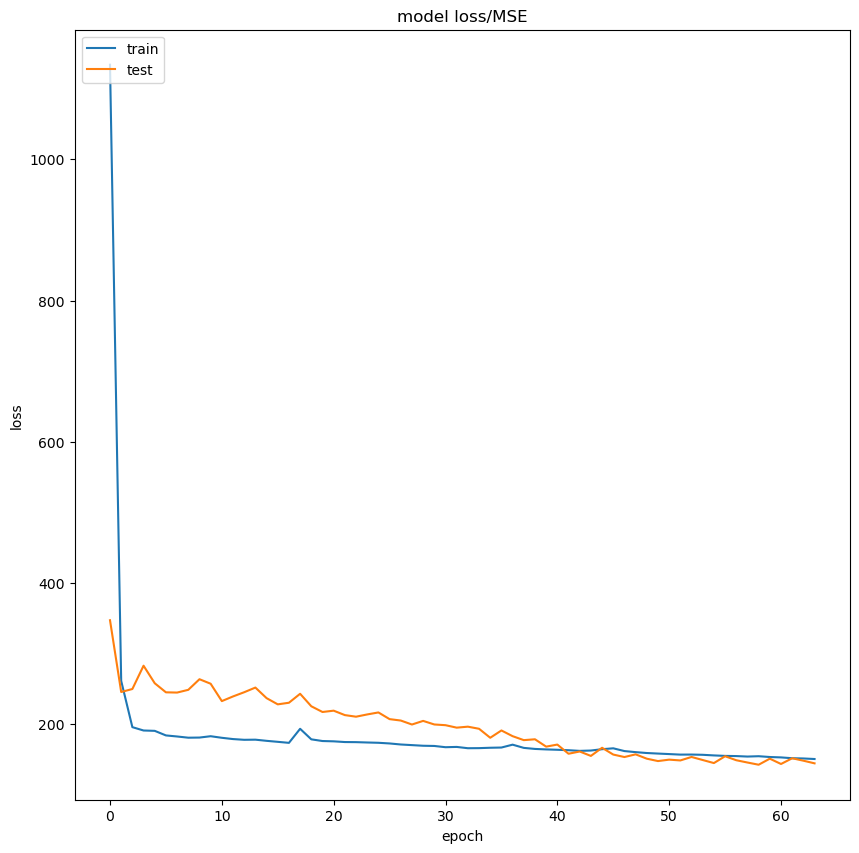

In [11]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

312/312 - 2s - 7ms/step - loss: 186.1024 - mse: 186.1024

MSE: 186.10244750976562


312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


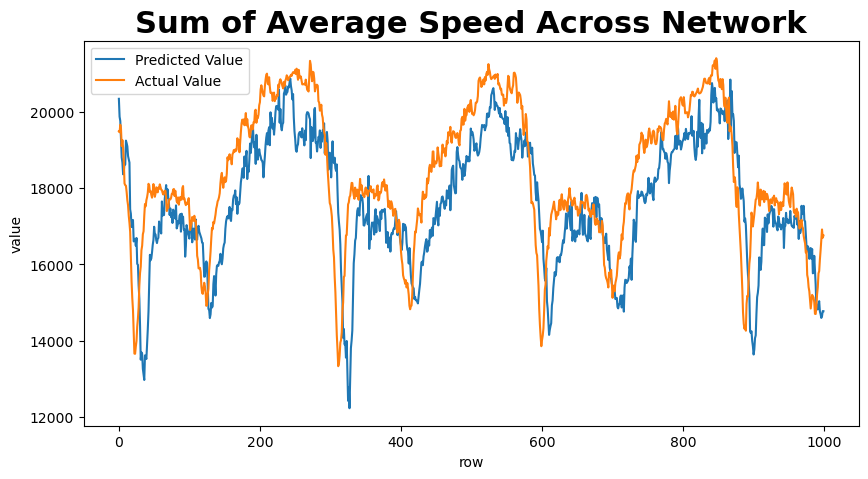

In [13]:
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# aggregating for easier visualization
y_pred_dv = [row.sum() for row in y_pred_test]
y_true_dv = [row.sum() for row in y_true_test]

start = 5000
ts = 1000

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
plt.plot(y_true_dv[start:start+ts], label='Actual Value')
plt.title('Sum of Average Speed Across Network',
          fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()